This file transforms the dataset so that we remove all unnecessary characters, accents, stop words and stems the words to reduce the vocabulary

# Import libraries

## TODO: move to requirements.txt

In [1]:
!pip install stop-words
!pip install wordcloud
!pip install stanza
!pip install spacy-stanza

You should consider upgrading via the 'c:\users\saox\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\saox\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\saox\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\saox\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import re
import unidecode
from nltk.probability import FreqDist
from nltk.corpus import stopwords as swords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import stanza
import spacy_stanza
import itertools
import nltk
from nltk.stem import SnowballStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json

nltk.download('stopwords')
# Download the stanza model if necessary
stanza.download("es")
stemmer = SnowballStemmer("spanish")

# Initialize the pipeline
nlp = spacy_stanza.load_pipeline("es")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saox\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-11-11 22:08:22 INFO: Downloading default packages for language: es (Spanish)...


2021-11-11 22:08:23 INFO: File exists: C:\Users\saox\stanza_resources\es\default.zip.
2021-11-11 22:08:28 INFO: Finished downloading models and saved to C:\Users\saox\stanza_resources.
2021-11-11 22:08:28 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-11-11 22:08:28 INFO: Use device: cpu
2021-11-11 22:08:28 INFO: Loading: tokenize
2021-11-11 22:08:28 INFO: Loading: mwt
2021-11-11 22:08:28 INFO: Loading: pos
2021-11-11 22:08:28 INFO: Loading: lemma
2021-11-11 22:08:28 INFO: Loading: depparse
2021-11-11 22:08:29 INFO: Loading: ner
2021-11-11 22:08:30 INFO: Done loading processors!


# Load the dataset

In [3]:
df = pd.read_pickle('initiatives.pkl')

In [4]:
df.head()

,_id,author_parliamentarygroups,created,initiative_type,initiative_type_alt,reference,status,tagged,title,updated,url,tags,topics,history,author_others,place,content,extra,author_deputies
0,8340a50c3e322491545cf6c40b0b3d29ed03cb85,[Grupo Parlamentario Ciudadanos],{'$date': '2020-06-02T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000004,Desconocida,True,"Reprobación del Ministro del Interior, don Fer...",{'$date': '2020-06-09T00:00:00Z'},https://www.congreso.es/web/guest/indice-de-in...,[],[],NaN,NaN,NaN,NaN,NaN,NaN
1,06709837ef704e5aaacfa6ea400517c560ebdd53,[Grupo Parlamentario Republicano],{'$date': '2021-03-18T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000022,Desconocida,True,Reprobación de la Ministra de Defensa.,{'$date': '2021-03-23T00:00:00Z'},https://www.congreso.es/web/guest/indice-de-in...,[],[],NaN,NaN,NaN,NaN,NaN,NaN
2,08cee188414ee529ca4dc998340791bae832029f,[Grupo Parlamentario Popular],{'$date': '2021-03-25T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000023,Desconocida,True,Reprobación de la Ministra de Educación y Form...,{'$date': '2021-04-06T00:00:00Z'},https://www.congreso.es/web/guest/indice-de-in...,[],[],NaN,NaN,NaN,NaN,NaN,NaN
3,70e6ca135dfb404955c15cf109c2a3614951528f,[Grupo Parlamentario Ciudadanos],{'$date': '2021-02-08T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000021,Desconocida,True,Reprobación del Vicepresidente Segundo del Gob...,{'$date': '2021-02-16T00:00:00Z'},https://www.congreso.es/web/guest/indice-de-in...,[],[],NaN,NaN,NaN,NaN,NaN,NaN
4,48643b81ce1cd97cbe74ceb711eaafb7ead9241f,[Grupo Parlamentario Popular],{'$date': '2020-06-02T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000003,Desconocida,True,Reprobación del Ministro del Interior.,{'$date': '2020-06-09T00:00:00Z'},https://www.congreso.es/web/guest/indice-de-in...,[],[],NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# If content is not present, use the title as content
df['content_coalesce'] = df['content'].combine_first(df['title'])

In [6]:
# test
df[df['content'].isna()][['content_coalesce','title','content']]

,content_coalesce,title,content
0,"Reprobación del Ministro del Interior, don Fer...","Reprobación del Ministro del Interior, don Fer...",NaN
1,Reprobación de la Ministra de Defensa.,Reprobación de la Ministra de Defensa.,NaN
2,Reprobación de la Ministra de Educación y Form...,Reprobación de la Ministra de Educación y Form...,NaN
3,Reprobación del Vicepresidente Segundo del Gob...,Reprobación del Vicepresidente Segundo del Gob...,NaN
4,Reprobación del Ministro del Interior.,Reprobación del Ministro del Interior.,NaN
...,...,...,...
110187,Recurso de inconstitucionalidad número 2379/20...,Recurso de inconstitucionalidad número 2379/20...,NaN
110188,Sentencia dictada por el citado Tribunal en el...,Sentencia dictada por el citado Tribunal en el...,NaN
110189,Cuestión de inconstitucionalidad número 3523/2...,Cuestión de inconstitucionalidad número 3523/2...,NaN
110190,Informe de Gestión del ejercicio 2020.,Informe de Gestión del ejercicio 2020.,NaN


In [7]:
# THIS FLATTENS the conetent from lists to str
df['content_coalesce'] = [''.join(l) for l in df['content_coalesce']]

In [8]:
# Here we flatten and then create lists of the individual words
# df['lists_content_coalesce'] = [''.join(l).split(" ") for l in df['content_coalesce']]

# Define helper functions

In [2]:
def create_df_from_json(file_path, columns_to_keep=['content','title','initiative_type_alt'],field_name='initiatives'):
    with open(file_path,'r', encoding="utf8") as f:
        data = json.loads(f.read())
    data_frame = pd.json_normalize(data,record_path=field_name)
    data_frame = data_frame[columns_to_keep]
    return(data_frame)

def retrieve_stop_words():
    spanish_stopwords = swords.words('spanish')
    stop_words_spanish = get_stop_words('spanish')
    stopwords = list(set(spanish_stopwords + stop_words_spanish))
    return stopwords

def space_out_your_text(row):
    doc = nlp(row)
    cleaned = ""
    for token in doc:
        if token.pos_ not in ("PUNCT","ADP","SCONJ","PRON","CCONJ"):
            #print(token.text, token.lemma_, token.pos_, token.dep_)
            cleaned+=token.lemma_+" "
    return cleaned


def remove_accents(row,column):
    return unidecode.unidecode(row[column])

#remove special characters
def replace_special_char(row):
    for word, initial in {".":" ", 
                          "-":" ",
                          "/":" ",
                          "@":" ",
                          "#":" ",
                          "(":" ",
                          ")":" ",
                          '"' : "",
                          " ,":"", 
                          ">":"",
                          "<":"",
                          "*":"",
                          ",":" ",
                          ":":"",
                          "?":"",
                          "'":"",
                          "%":"",
                          "+":" ",
                          "&":"",
                          "\n":" ",
                         "\\":""}.items(): #special case - comma becomes space just in case
        row = row.replace(word, initial) 
    return row

def remove_stopwords(row, stopwords):
    removed_stopwords = " ".join([word for word in row.split(" ") if word not in stopwords and word.replace(" ","")!=""])
    return removed_stopwords


def remove_numbers(col):
    return col.str.replace('\d+', '')


def unique_words(col):
    words = col.str.lower().str.findall("\w+")
    unique = set()

    for x in words:
        unique.update(x)
    return unique

def unique_words_using_vectorizer(text_column):
    # tokenize and build vocab
    vectorizer = CountVectorizer()
    vectorizer.fit(text_column)
    # summarize
#     print(vectorizer.vocabulary_)
    # encode document
    vector = vectorizer.transform(text_column)
    # summarize encoded vector
    print(vector.shape)


def word_count(df):
    tf = df['text'].apply(lambda x: FreqDist(x)).sum(axis = 0)
    tf2 = dict(tf)
    data_items = tf2.items()
    data_list = list(data_items)
    freq_dataframe = pd.DataFrame(data_list)
    freq_dataframe.columns = ['Word','Counts']
    freq_dataframe = freq_dataframe.sort_values(by="Counts",ascending=False)
    pd.set_option("max_rows", None)
    return freq_dataframe

# Starting with this many unique words

In [10]:
unique_words_using_vectorizer(df['content_coalesce'])

(110192, 693513)


# Get stopwords

In [11]:
stop_words = retrieve_stop_words()
#apply same transformations as on the corpus
stop_words = [unidecode.unidecode(each_string.lower()) for each_string in stop_words]

In [12]:
len(stop_words)

315

# Wordcloud Per Category

In [7]:
test_df.initiative_type_alt.value_counts()

Proposición no de Ley en Comisión                     6
Proyecto de ley                                       5
Interpelación urgente                                 2
Moción consecuencia de interpelación urgente          2
Proyecto de reforma constitucional                    1
Solicitud de informe a Comunidad Autónoma (art. 7)    1
Otras comparecencias en Comisión                      1
Proposición de ley del Senado                         1
Propuesta de reforma de Estatuto de Autonomía         1
Name: initiative_type_alt, dtype: int64

Interpelación urgente


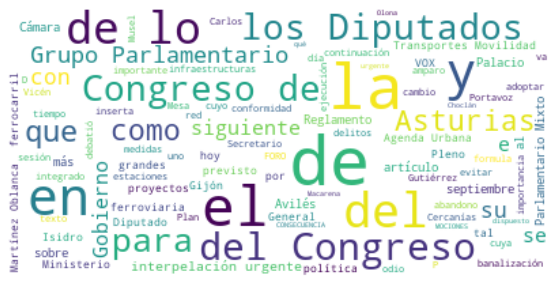

Moción consecuencia de interpelación urgente


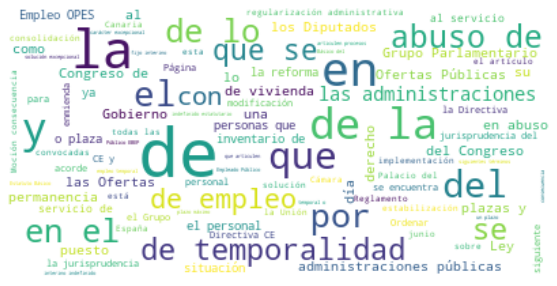

Otras comparecencias en Comisión
Proposición de ley del Senado


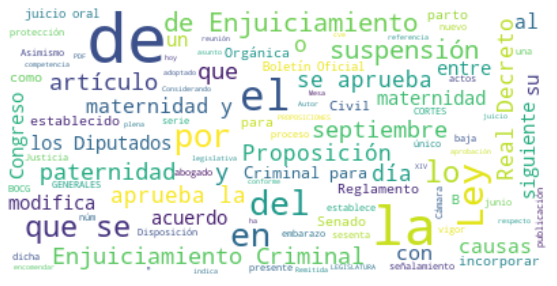

Proposición no de Ley en Comisión


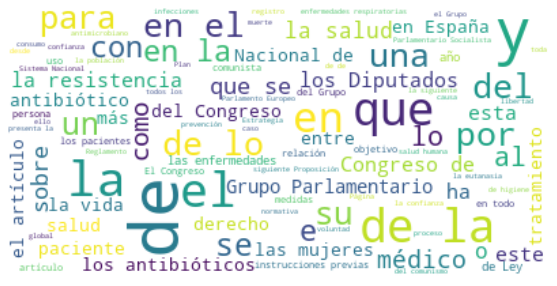

Propuesta de reforma de Estatuto de Autonomía


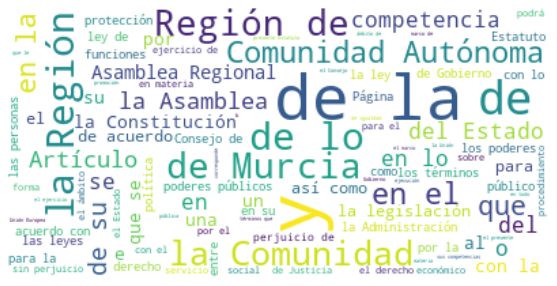

Proyecto de ley


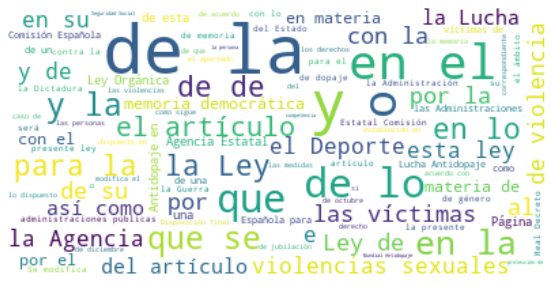

Proyecto de reforma constitucional


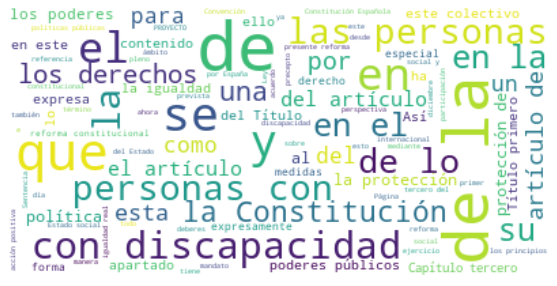

Solicitud de informe a Comunidad Autónoma (art. 7)


In [5]:
# example usage: test_df = create_df_from_json('./small-batch.json')
test_df = create_df_from_json('small-batch.json') 

grouped = test_df.groupby("initiative_type_alt")['content'].apply(lambda tags: ','.join(tags))

def show_cloud(i):
    text = grouped[i]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

for i, row in grouped.iteritems():
    unique_id = i
    print(i)
    if len(grouped[i])>0:
        show_cloud(i)

# Spot check

In [14]:
# list(df[df._id == 'ea99726d258373625ba3210f46c8ae07113ce965']['content'])

# Apply transformations one-by-one

## Original content

In [15]:
unique_words_using_vectorizer(df['content_coalesce'])

(110192, 693513)


## Remove accents

In [16]:
df['t1_no_accents'] = df.apply(lambda row:remove_accents(row,'content_coalesce'),axis=1)
df['t1_no_accents'].head()

0    Reprobacion del Ministro del Interior, don Fer...
1               Reprobacion de la Ministra de Defensa.
2    Reprobacion de la Ministra de Educacion y Form...
3    Reprobacion del Vicepresidente Segundo del Gob...
4               Reprobacion del Ministro del Interior.
Name: t1_no_accents, dtype: object

In [17]:
# list(df[df._id == 'ea99726d258373625ba3210f46c8ae07113ce965']['t1_no_accents'])

In [18]:
unique_words_using_vectorizer(df['t1_no_accents'])

(110192, 685318)


## Remove numbers

In [19]:
df['t2_no_numbers'] = remove_numbers(df['t1_no_accents']) 
df['t2_no_numbers'].head()

0    Reprobacion del Ministro del Interior, don Fer...
1               Reprobacion de la Ministra de Defensa.
2    Reprobacion de la Ministra de Educacion y Form...
3    Reprobacion del Vicepresidente Segundo del Gob...
4               Reprobacion del Ministro del Interior.
Name: t2_no_numbers, dtype: object

In [20]:
unique_words_using_vectorizer(df['t2_no_numbers'])

(110192, 339505)


## Remove special characters

In [21]:
df['t3_no_special_char'] = df['t2_no_numbers'].apply(lambda row:replace_special_char(row))
df['t3_no_special_char'].head()

0    Reprobacion del Ministro del Interior  don Fer...
1               Reprobacion de la Ministra de Defensa 
2    Reprobacion de la Ministra de Educacion y Form...
3    Reprobacion del Vicepresidente Segundo del Gob...
4               Reprobacion del Ministro del Interior 
Name: t3_no_special_char, dtype: object

In [22]:
unique_words_using_vectorizer(df['t3_no_special_char'])

(110192, 348990)


## Lowercase all

In [23]:
df['t4_lowercase'] = df['t3_no_special_char'].str.lower()
df['t4_lowercase'].head()

0    reprobacion del ministro del interior  don fer...
1               reprobacion de la ministra de defensa 
2    reprobacion de la ministra de educacion y form...
3    reprobacion del vicepresidente segundo del gob...
4               reprobacion del ministro del interior 
Name: t4_lowercase, dtype: object

In [24]:
unique_words_using_vectorizer(df['t4_lowercase'])

(110192, 348990)


## Remove Stopwords

In [25]:
df['t5_stopwords_removed'] = df['t4_lowercase'].apply(lambda row:remove_stopwords(row, stop_words))
df['t5_stopwords_removed'].head()

0    reprobacion ministro interior don fernando gra...
1                         reprobacion ministra defensa
2    reprobacion ministra educacion formacion profe...
3          reprobacion vicepresidente segundo gobierno
4                        reprobacion ministro interior
Name: t5_stopwords_removed, dtype: object

In [26]:
unique_words_using_vectorizer(df['t5_stopwords_removed'])

(110192, 348847)


## Stem words

In [27]:
df['t6_stemming'] = df["t5_stopwords_removed"].apply(lambda row: [stemmer.stem(x) for x in row.split(" ")])
df['t6_stemming'].head()

0    [reprobacion, ministr, interior, don, fern, gr...
1                       [reprobacion, ministr, defens]
2    [reprobacion, ministr, educacion, formacion, p...
3        [reprobacion, vicepresident, segund, gobiern]
4                     [reprobacion, ministr, interior]
Name: t6_stemming, dtype: object

In [28]:
# THIS FLATTENS the list from list to str
df['t6_stemming'] = [' '.join(l) for l in df['t6_stemming']]

In [29]:
unique_words_using_vectorizer(df['t6_stemming'])

(110192, 282017)


# Checkpoint

In [30]:
save_cols = ['_id', 'author_parliamentarygroups', 'created', 'initiative_type',
       'initiative_type_alt', 'reference', 'status', 'tagged', 'title',
       'updated', 'url', 'tags', 'topics', 'history', 'author_others', 'place',
       'content', 'extra', 'author_deputies', 'content_coalesce', 't6_stemming']
df[save_cols].to_csv("preprocessed.csv")

In [31]:
# df2['tokenized_sents'] = df2.apply(lambda row: nlp(row['removed_num']), axis=1)
# df2['tokenized_sents_str'] = df2.tokenized_sents.apply(lambda x:str(x))

# infreq = freq_dataframe[freq_dataframe['Counts'] < 3 ]['Word'].tolist()


# df2['removed_infreq'] = df2.tokenized_sents_str.apply(lambda x: remove_stopwords(x,infreq))
# df2['removed_infreq_str'] = df2.removed_infreq.apply(lambda x:str(x))



# v = TfidfVectorizer()
# x = v.fit_transform(df2['removed_infreq_str'])
# x.todense()
# len(v.vocabulary_)

In [32]:
# from collections import Counter
# from itertools import chain

# counter = Counter(chain.from_iterable(map(str.split, df.t5_stopwords_removed.tolist())))

# df['count'] = df['content_coalesce'].str.split().str.len()
# df['count2'] = df['t5_stopwords_removed'].str.split().str.len()